# Galaxy vs Quasar

### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import corner
import os
import numpy as np
import pandas as pd
import sklearn.metrics as skm
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from astroML.classification import GMMBayes
from sklearn import metrics

In [3]:
def classification (classifier, x_train, y_train, x_test, y_test, n_colors):

    clf = classifier
    clf.fit(x_train[:, 0:n_colors], y_train)
    
    prediction = clf.predict(x_test[:, 0:n_colors])
    
    y_prob = clf.predict_proba(x_test[:, 0:n_colors])[:, 1] 
    fpr, tpr, tresh = skm.roc_curve(y_test, y_prob)

    thresholds = np.linspace(0, 1, 1001)[:-1]
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)

    return fpr, tpr, comp, cont

Reading the data and build the colors

In [4]:
GAL_COLORS_NAMES = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

data_pd = pd.read_csv('galaxyquasar.csv')

# Taking the colors from the data
col_ug = np.array( data_pd.get(GAL_COLORS_NAMES[0]) - data_pd.get(GAL_COLORS_NAMES[1]))
col_gr = np.array( data_pd.get(GAL_COLORS_NAMES[1]) - data_pd.get(GAL_COLORS_NAMES[2]))
col_ri = np.array( data_pd.get(GAL_COLORS_NAMES[2]) - data_pd.get(GAL_COLORS_NAMES[3]))
col_iz = np.array( data_pd.get(GAL_COLORS_NAMES[3]) - data_pd.get(GAL_COLORS_NAMES[4]))

# Encoding the classes in the dataset:
# Put some integer numbers as labels
le = LabelEncoder()

#print(data_pd['class'])

classes = le.fit_transform(data_pd['class'])
labels = le.inverse_transform(classes)
class_names = le.classes_
#print(class_names)

print(classes)
print(labels)
#print(np.shape(labels))

[1 0 0 ... 0 0 0]
['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


I split the data in training and test set

In [5]:
# Splitting the data in useful way!

colors_label = ['u-g', 'g-r', 'r-i', 'i-z']
N_colors = np.array([1, 2, 3, 4])

# (4, N) 4 features and N data array
full_colors = np.array([col_ug, col_gr, col_ri, col_iz])
print(np.shape(full_colors))

# Convert the array in (N_samples, N_features)
full_colors = full_colors.T
print(np.shape(full_colors))

# Splitting the data for machine learning:
# The point is that for each color I have the same label classification
x_training_colors, x_test_colors, y_training_colors, y_test_colors  = train_test_split(full_colors, classes, test_size = 0.3, random_state = 7)

# I have a training set and a test set for each feature
print(np.shape(x_training_colors))


(4, 50000)
(50000, 4)
(35000, 4)


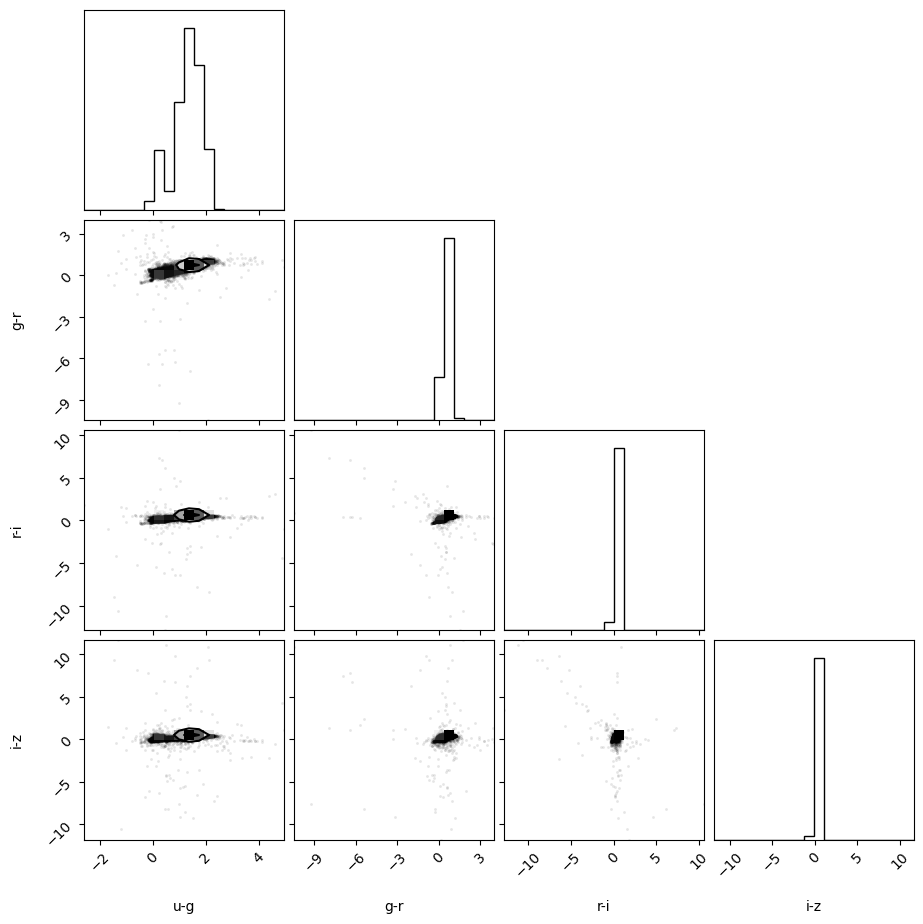

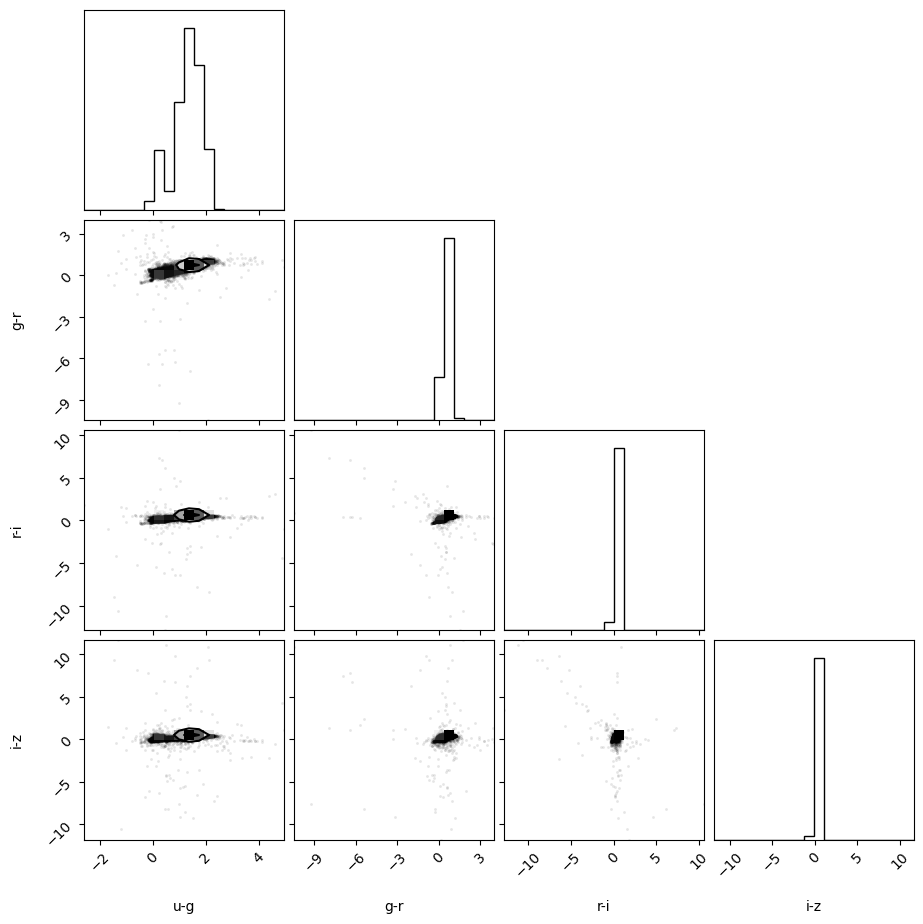

In [6]:
corner.corner(full_colors, labels=['u-g', 'g-r', 'r-i', 'i-z'])

## Classifiers

Here I try a lot of different classifiers to see how they perform on the data.

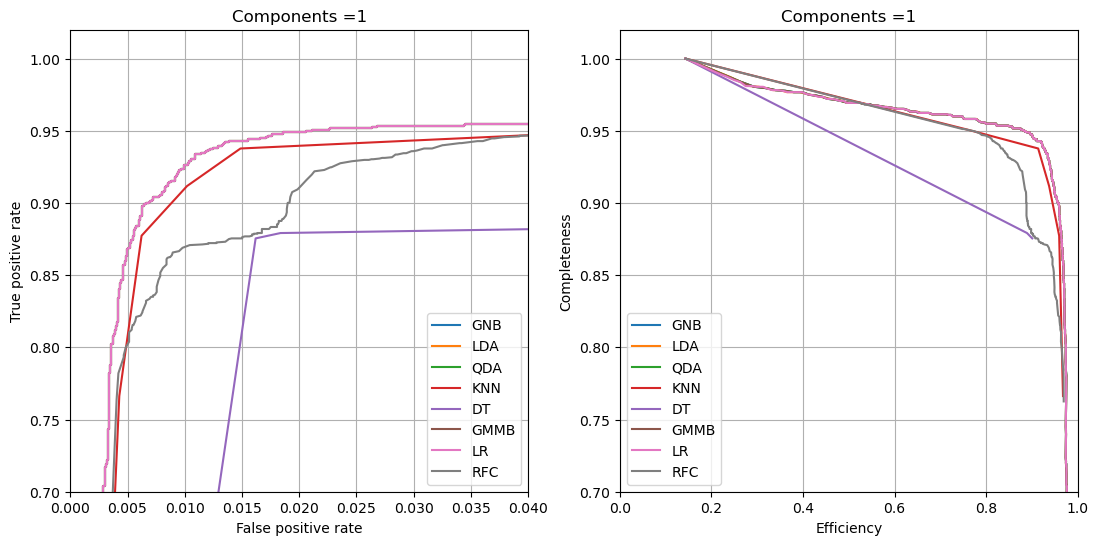

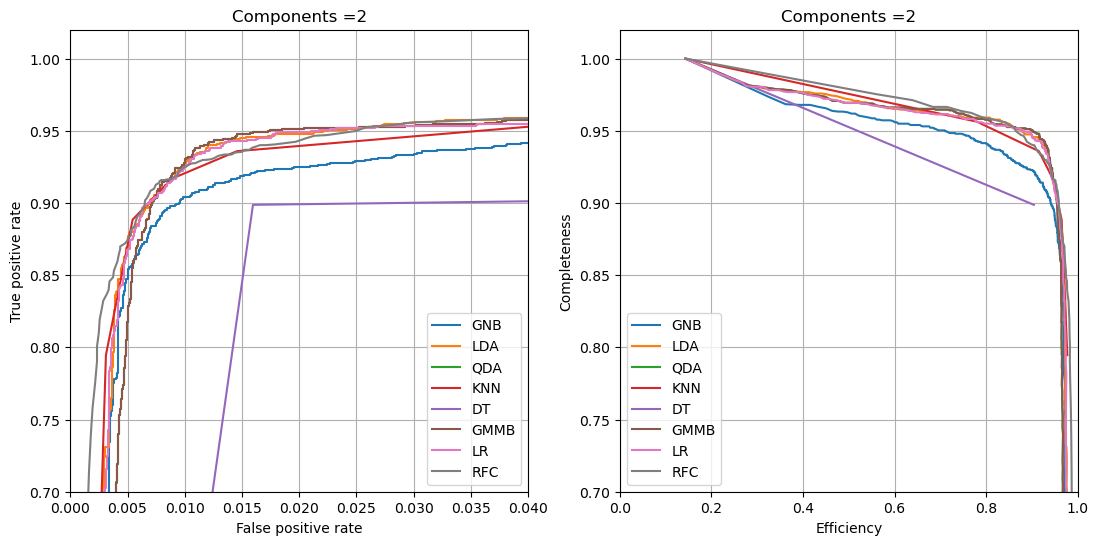

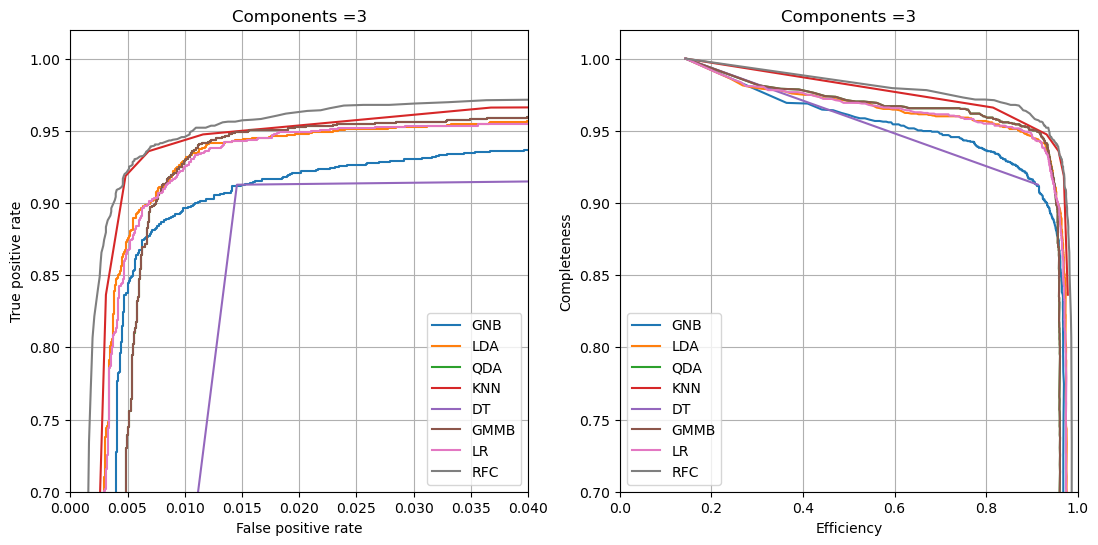

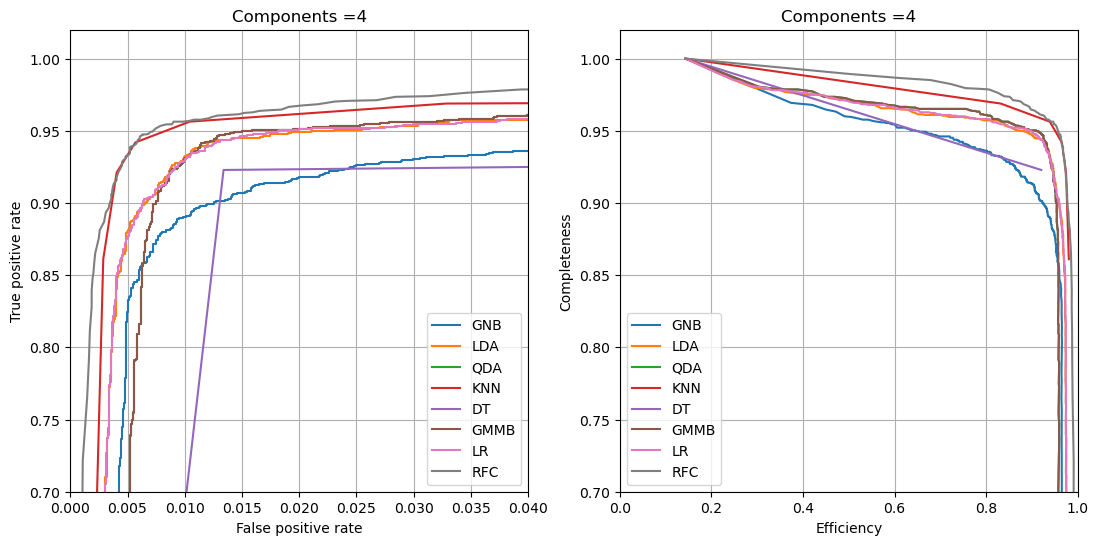

In [32]:
labels = ['GNB', 'LDA', 'QDA', 'KNN', 'DT', 'GMMB', 'LR', 'RFC']

for N in range(1, 5):
    
    fpr_GNB, tpr_GNB, comp_GNB, cont_GNB = classification (GaussianNB(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)
    fpr_LDA, tpr_LDA, comp_LDA, cont_LDA = classification (LinearDiscriminantAnalysis(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)
    fpr_QDA, tpr_QDA, comp_QDA, cont_QDA = classification (QuadraticDiscriminantAnalysis(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)
    fpr_KNN, tpr_KNN, comp_KNN, cont_KNN = classification (KNeighborsClassifier(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, n_colors = N)
    fpr_DT, tpr_DT, comp_DT, cont_DT = classification (DecisionTreeClassifier(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, n_colors = N)
    fpr_GMMB, tpr_GMMB, comp_GMMB, cont_GMMB = classification (GMMBayes(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, n_colors = N)
    fpr_LR, tpr_LR, comp_LR, cont_LR = classification (LogisticRegression(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, n_colors = N)
    fpr_RFC, tpr_RFC, comp_RFC, cont_RFC = classification (RandomForestClassifier(), x_training_colors, y_training_colors, x_test_colors, y_test_colors, n_colors = N)
    
    comp_arr = np.array([comp_GNB, comp_LDA, comp_QDA, comp_KNN, comp_DT, comp_GMMB, comp_LR, comp_RFC])
    cont_arr = np.array([cont_GNB, cont_LDA, cont_QDA, cont_KNN, cont_DT, cont_GMMB, cont_LR, cont_RFC])
    fpr_arr = [fpr_GNB, fpr_LDA, fpr_QDA, fpr_KNN, fpr_DT, fpr_GMMB, fpr_LR, fpr_RFC]
    tpr_arr = [tpr_GNB, tpr_LDA, tpr_QDA, tpr_KNN, tpr_DT, tpr_GMMB, tpr_LR, tpr_RFC]
    
    fig = plt.figure(figsize = (13, 6))
        
    # Plot completeness vs contamination
    ax = plt.subplot(122)
    k = 0
    
    for i, j in zip(comp_arr, cont_arr):
        ax.plot(1 - j, i, label = labels[k])
        k = k+1

    plt.legend()
    plt.title('Components =' +str(N))
    ax.set_ylabel('Completeness')
    ax.set_xlabel('Efficiency')
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0.7, 1.02)
    ax.grid(True)
    
    # Plot ROC curves
    k = 0
    ax = plt.subplot(121)
    for i in range(len(fpr_arr)):
        ax.plot(fpr_arr[i], tpr_arr[i], label = labels[k])
        k = k+1
        
    plt.legend()
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_xlim(0, 0.04)
    ax.set_ylim(0.7, 1.02)
    ax.grid(True)
    
    plt.title('Components =' +str(N))
    plt.show()


## Single classifiers

If I want to study how a single one of this perform using different components, I can take only one classifier and work out all of these curves. I define a function to plot the ROC and Completness curves

In [8]:
def ROC_plots (clf, label, x_training, y_training, x_test, y_test, N):
    
    comp_arr, cont_arr, fpr_arr, tpr_arr = [], [], [], []
    
    for N in range(1, 5):
        
        fpr, tpr, comp, cont = classification (clf, x_training, y_training, x_test, y_test, N)
        
        comp_arr.append(comp)
        cont_arr.append(cont)
        fpr_arr.append(fpr)
        tpr_arr.append(tpr)
        
    fig = plt.figure(figsize = (13, 6))
            
    # Plot completeness vs contamination
    ax = plt.subplot(122)
    k = 0
        
    for i, j in zip(comp_arr, cont_arr):
        ax.plot(1 - j, i, label = str(k + 1))
        k = k+1
    
    plt.legend()
    plt.title(label)
    ax.set_ylabel('Completeness')
    ax.set_xlabel('Efficiency')
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0.7, 1.02)
    ax.grid(True)
        
    # Plot ROC curves
    k = 0
    ax = plt.subplot(121)
    for i in range(len(fpr_arr)):
        ax.plot(fpr_arr[i], tpr_arr[i], label = str(k + 1))
        k = k+1
            
    plt.legend()
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_xlim(0, 0.04)
    ax.set_ylim(0.7, 1.02)
    ax.grid(True)
        
    plt.title(label)
    plt.show()

    return metrics.confusion_matrix(y_test, clf.predict(x_test))

In [9]:
N = 4

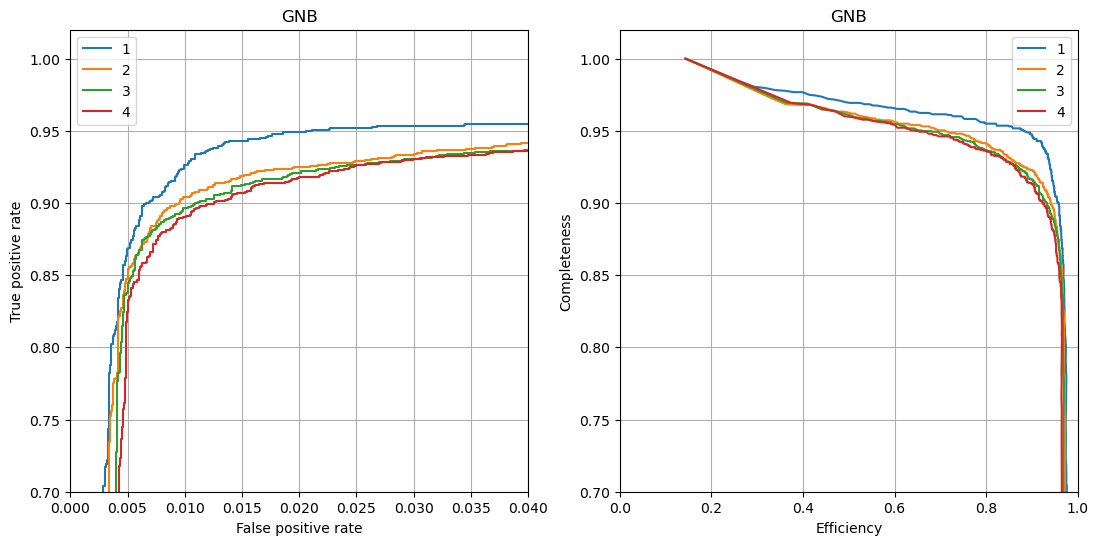

In [10]:
C_mat_GNB = ROC_plots(GaussianNB(), 'GNB', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

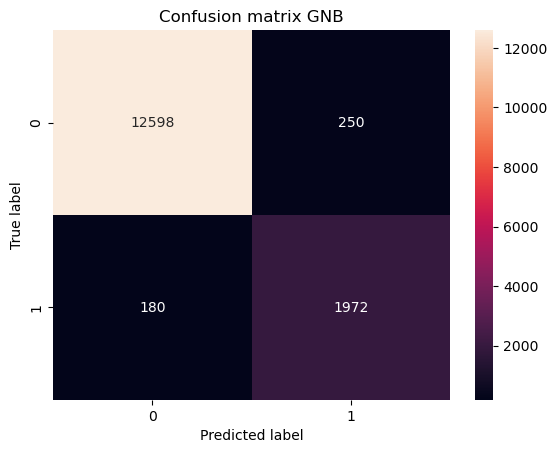

In [11]:
sns.heatmap(C_mat_GNB, annot = True, fmt="d")
plt.title('Confusion matrix GNB')
plt.ylabel('True label')
plt.xlabel('Predicted label')

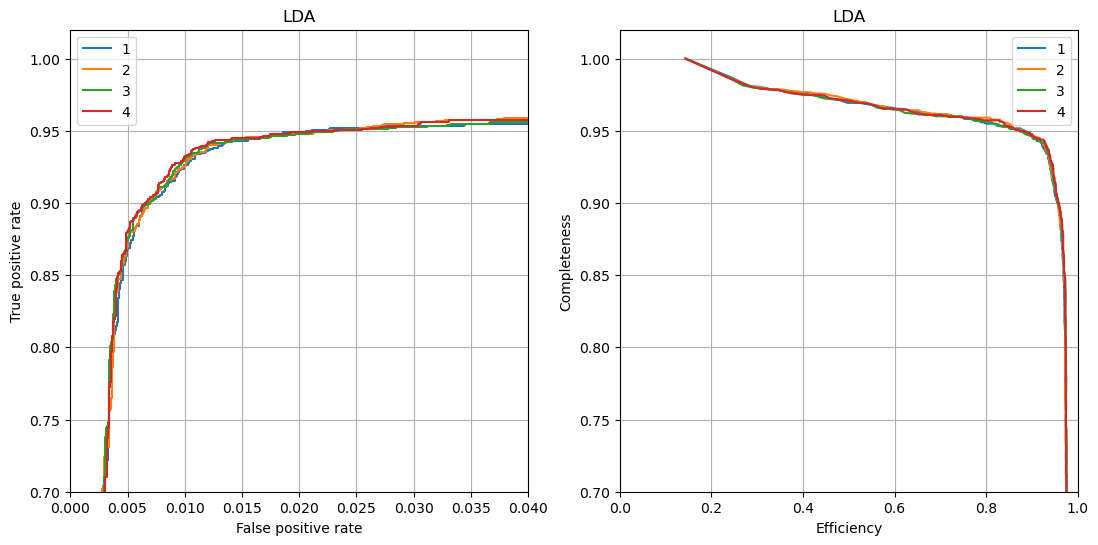

In [12]:
C_mat_LDA = ROC_plots(LinearDiscriminantAnalysis(), 'LDA', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

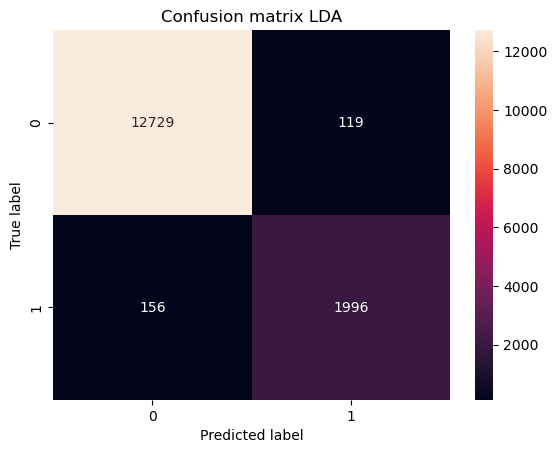

In [14]:
sns.heatmap(C_mat_LDA, annot = True, fmt="d")
plt.title('Confusion matrix LDA')
plt.ylabel('True label')
plt.xlabel('Predicted label')

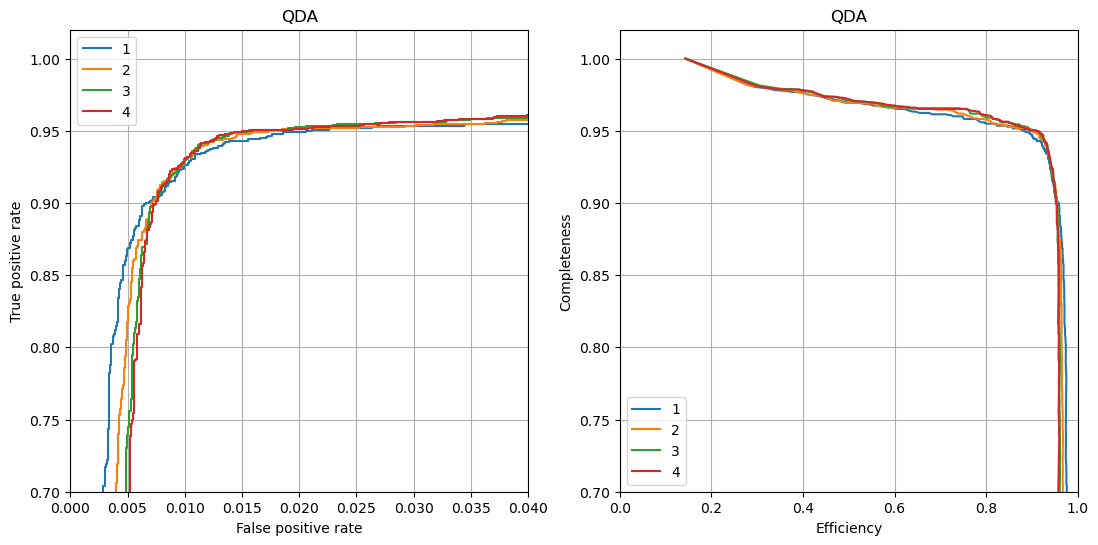

In [33]:
C_mat_QDA = ROC_plots(QuadraticDiscriminantAnalysis(), 'QDA', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

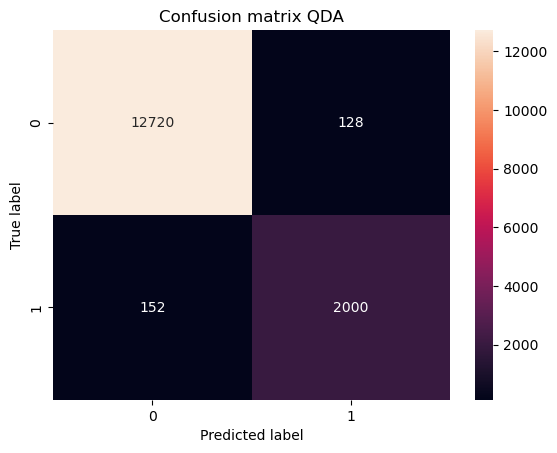

In [34]:
sns.heatmap(C_mat_QDA, annot = True, fmt="d")
plt.title('Confusion matrix QDA')
plt.ylabel('True label')
plt.xlabel('Predicted label')

 **Comment :** the confusion matrices of the different GNB, LDA and QDA are comparable, the classifiers behave almost at the same way on the dataset. LDA and QDA are slightly better in the ROC curves with 4 components than GNB, this mean that considering the covariances between the attributes has an observable impact; it doesn't really matter if the covariance is the same for each class (LDA) or different (QDA), the result is similar.

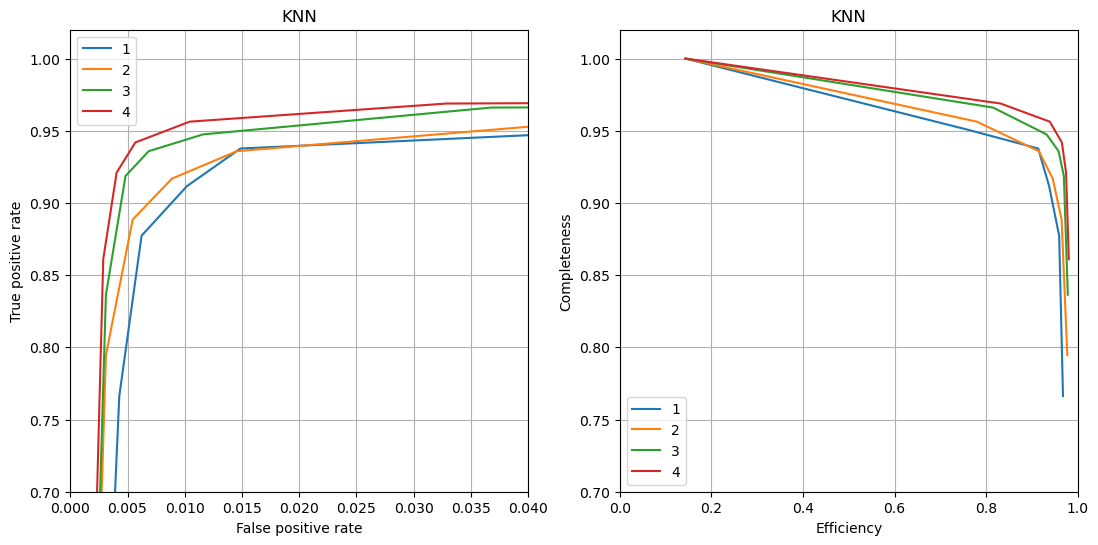

In [16]:
C_mat_KNN = ROC_plots(KNeighborsClassifier(), 'KNN', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

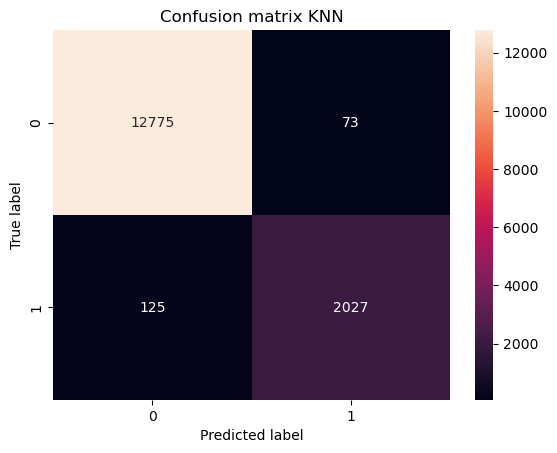

In [17]:
sns.heatmap(C_mat_KNN, annot = True, fmt="d")
plt.title('Confusion matrix KNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')

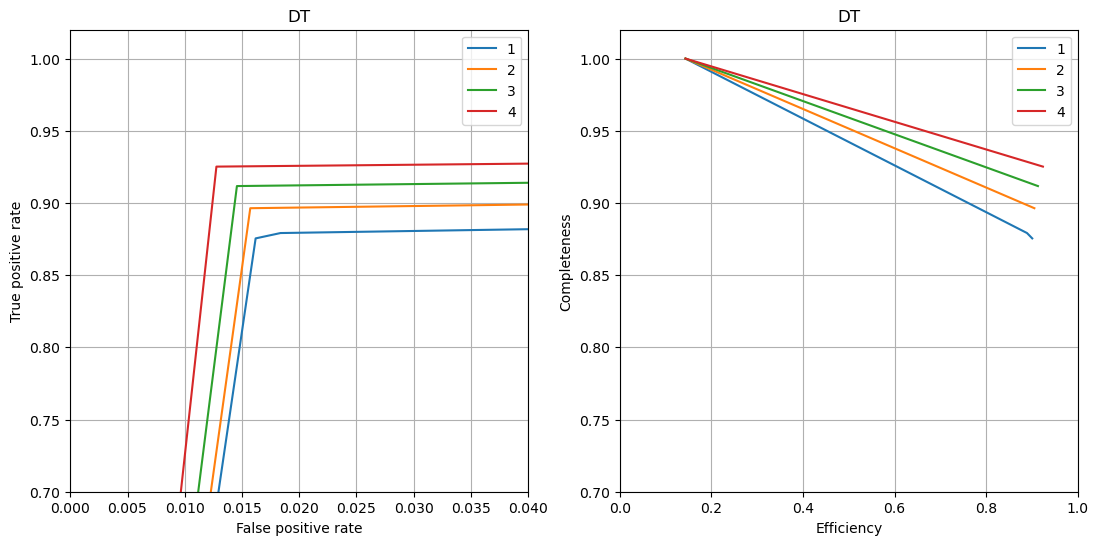

In [18]:
C_mat_DT = ROC_plots(DecisionTreeClassifier(), 'DT', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

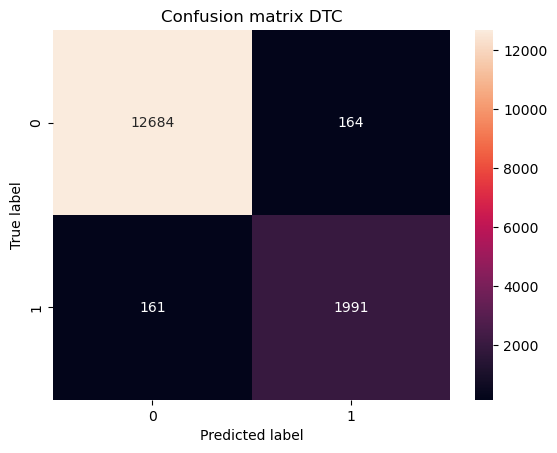

In [19]:
sns.heatmap(C_mat_DT, annot = True, fmt="d")
plt.title('Confusion matrix DTC')
plt.ylabel('True label')
plt.xlabel('Predicted label')

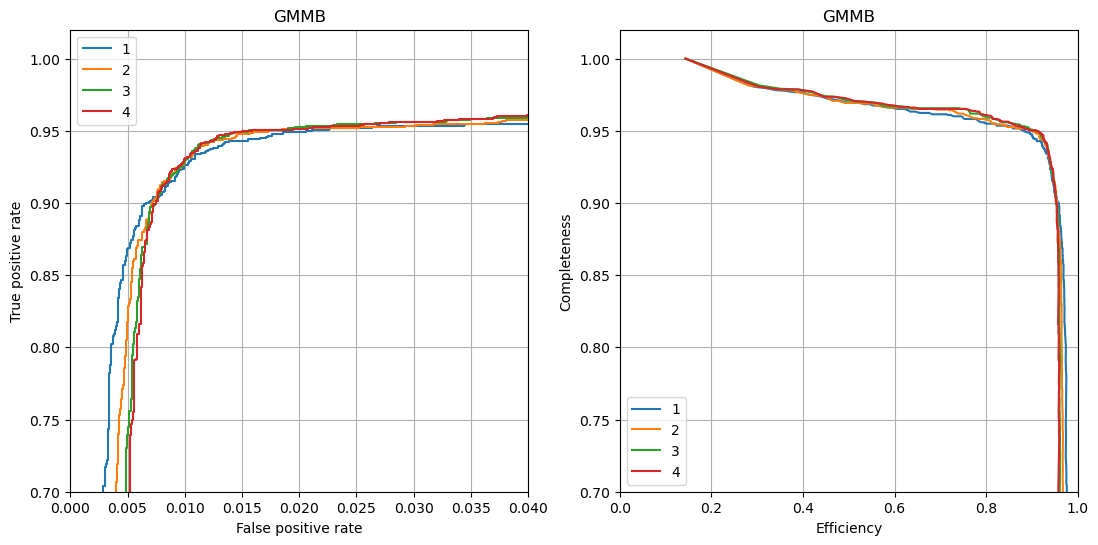

In [21]:
C_mat_GMMB = ROC_plots(GMMBayes(), 'GMMB', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

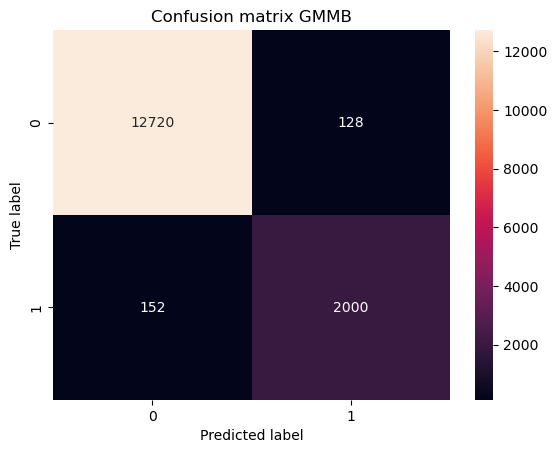

In [22]:
sns.heatmap(C_mat_GMMB, annot = True, fmt="d")
plt.title('Confusion matrix GMMB')
plt.ylabel('True label')
plt.xlabel('Predicted label')

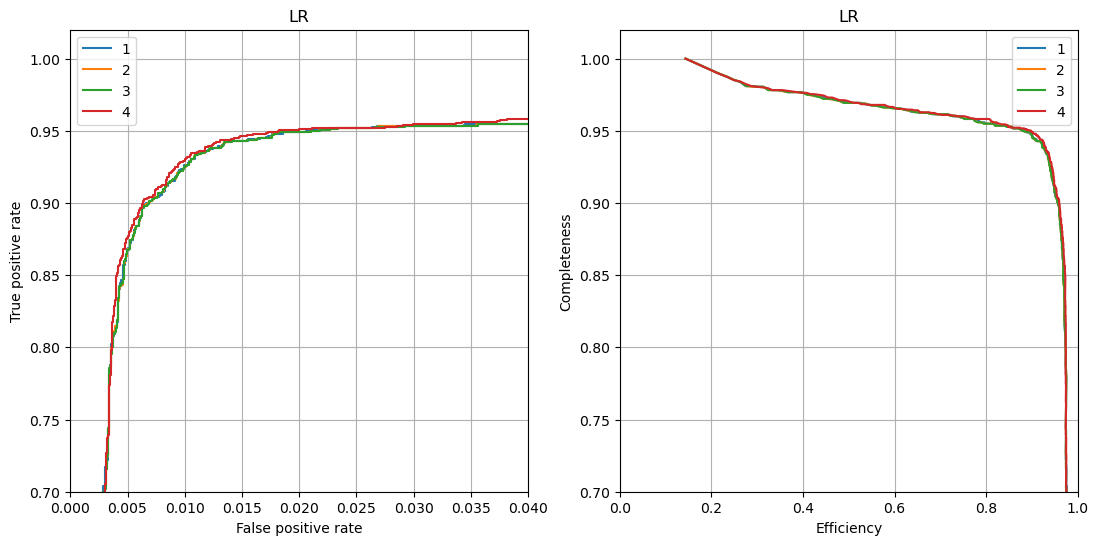

In [24]:
C_mat_LR = ROC_plots(LogisticRegression(), 'LR', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

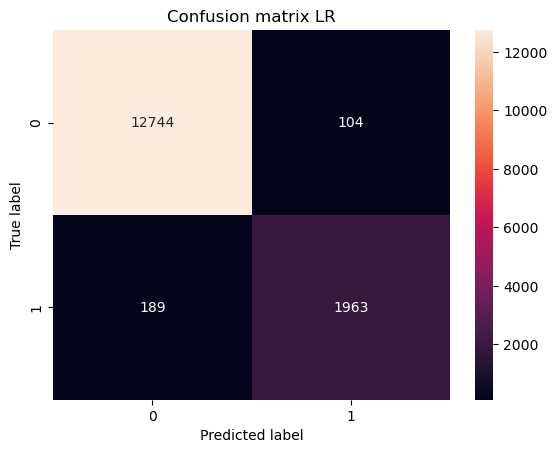

In [25]:
sns.heatmap(C_mat_LR, annot = True, fmt="d")
plt.title('Confusion matrix LR')
plt.ylabel('True label')
plt.xlabel('Predicted label')

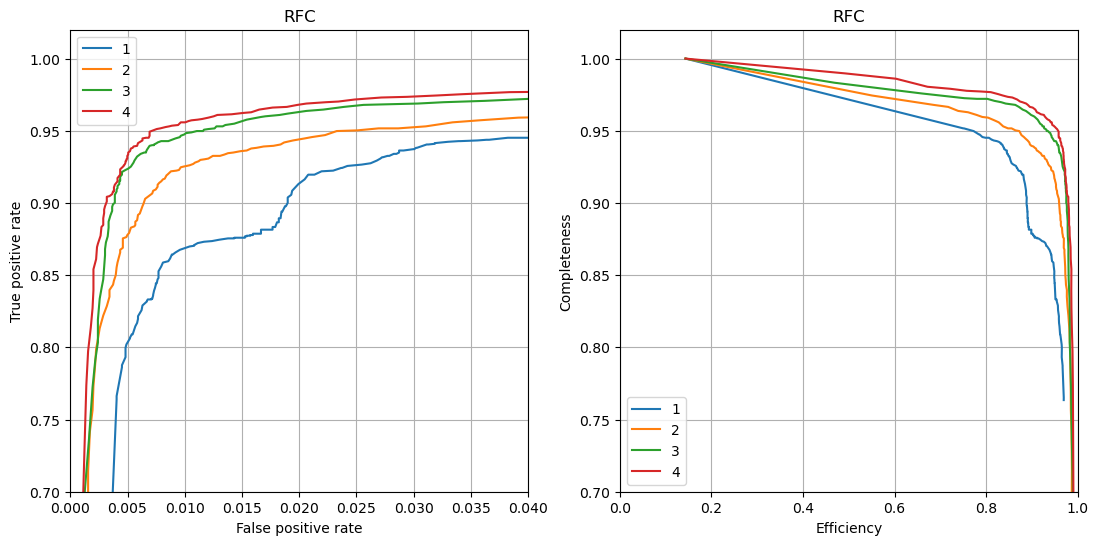

In [27]:
C_mat_RFC = ROC_plots(RandomForestClassifier(), 'RFC', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

Text(0.5, 23.52222222222222, 'Predicted label')

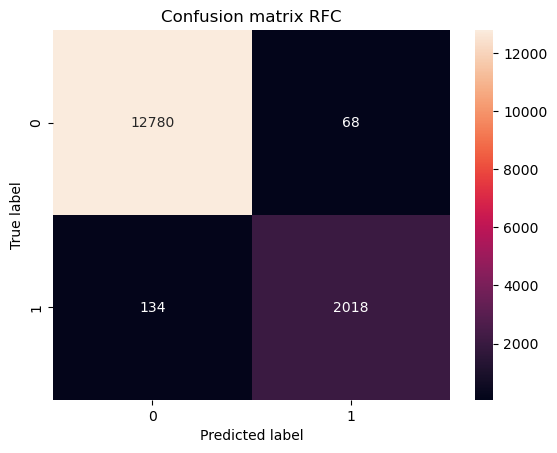

In [28]:
sns.heatmap(C_mat_RFC, annot = True, fmt="d")
plt.title('Confusion matrix RFC')
plt.ylabel('True label')
plt.xlabel('Predicted label')

From these plots, we can see that adding more components improves the ROC curves (in some cases significantly), but for the GNB case where more components produce a wrost result. 

Moreover it's important to underline that when I use the single component, I always pick the 'u-g' color, which probabily is the one with the most evident bimodal distribution and probabily the easiest to classify. It's should be tested switching the first component. I report a comparison with just one of the classifiers (KNN) before and after the switching the order of the components

## Switching components

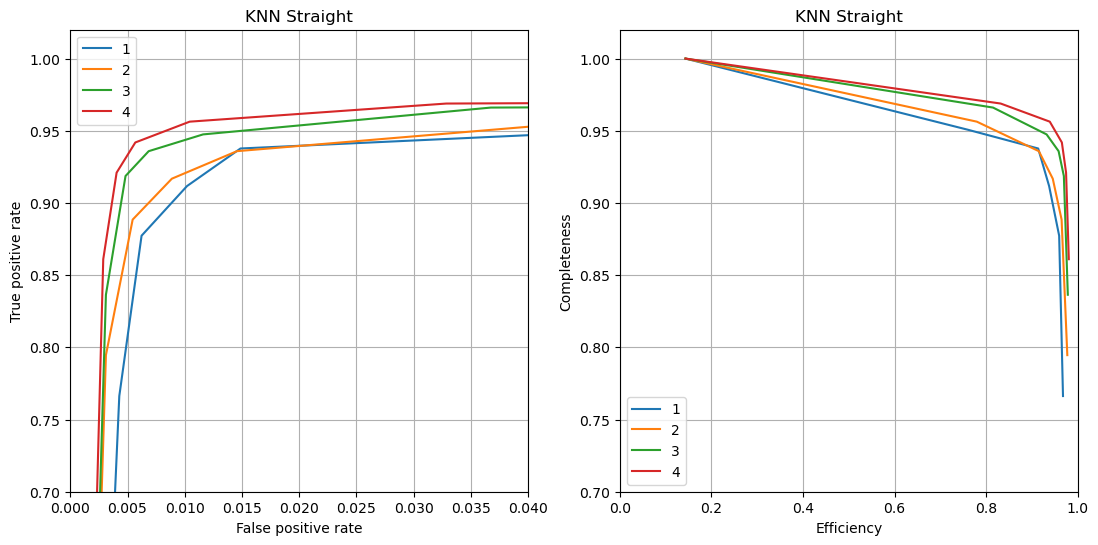

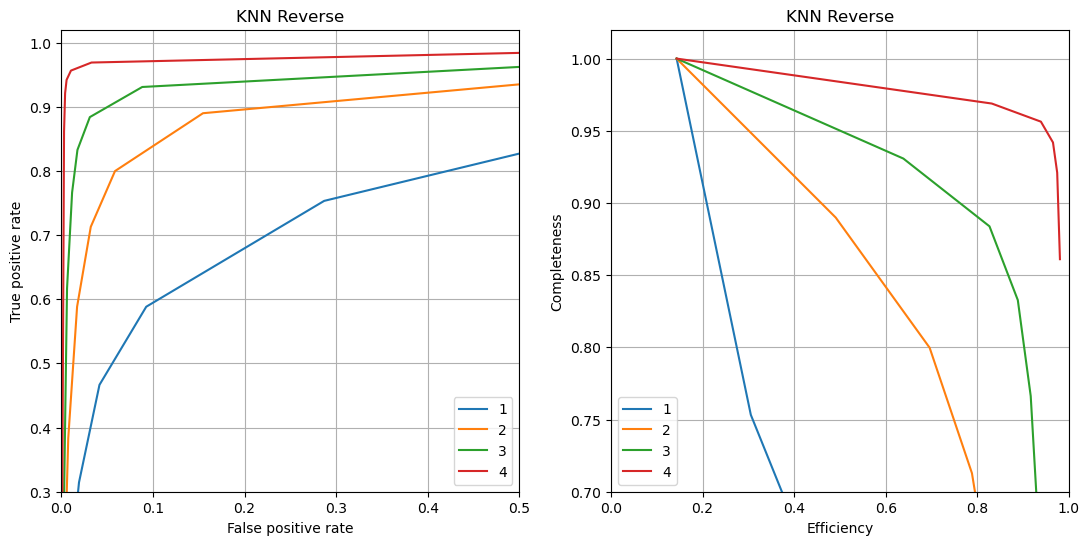

In [24]:
ROC_plots(KNeighborsClassifier(), 'KNN Straight', x_training_colors, y_training_colors, x_test_colors, y_test_colors, N)

# Splitting the data switching the components
colors_label_r = ['i-z', 'r-i', 'g-r', 'u-g']
N_colors_r = np.array([1, 2, 3, 4])

full_colors_r = np.array([col_iz, col_ri, col_gr, col_ug])
full_colors_r = full_colors_r.T
x_training_colors_r, x_test_colors_r, y_training_colors_r, y_test_colors_r  = train_test_split(full_colors_r, classes, test_size = 0.3, random_state = 7)

comp_arr, cont_arr, fpr_arr, tpr_arr = [], [], [], []

for N in range(1, 5):
    
    fpr, tpr, comp, cont = classification (KNeighborsClassifier(), x_training_colors_r, y_training_colors_r, x_test_colors_r, y_test_colors_r, N)
    
    comp_arr.append(comp)
    cont_arr.append(cont)
    fpr_arr.append(fpr)
    tpr_arr.append(tpr)
    
fig = plt.figure(figsize = (13, 6))
        
# Plot completeness vs contamination
ax = plt.subplot(122)
k = 0
    
for i, j in zip(comp_arr, cont_arr):
    ax.plot(1 - j, i, label = str(k + 1))
    k = k+1

plt.legend()
plt.title('KNN Reverse')
ax.set_ylabel('Completeness')
ax.set_xlabel('Efficiency')
ax.set_xlim(0, 1.0)
ax.set_ylim(0.7, 1.02)
ax.grid(True)
    
# Plot ROC curves
k = 0
ax = plt.subplot(121)
for i in range(len(fpr_arr)):
    ax.plot(fpr_arr[i], tpr_arr[i], label = str(k + 1))
    k = k+1
        
plt.legend()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_xlim(0, 0.5)
ax.set_ylim(0.3, 1.02)
ax.grid(True)
    
plt.title('KNN Reverse')
plt.show()


I see that when I switch the components' order, it's much better to take all of them to classify!